<a href="https://colab.research.google.com/github/Gaurav-phatkare/Medical-Abstract-Classifier-Deep-Learning-Approach/blob/main/NLP_Project_Medical_Abstract_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project On NLP
(On Basis of Fundamental Knowledge of NLP)

Many to one Problem because of multiple words input and label them with one output

Skimlit will take Abstract as an input and break it to the four sections namely Background, Methods, Results , Conclusion

Bi-LSTM model(According to the paper) will be use while building model

And the paper available at [this Link](https://arxiv.org/abs/1710.06071)

```
Input = Long Paragraph (Abstract)
Output = Background , Objectives , Methods , Results , Conclusion
```
Output should be like  **[0.01, 0.85, 0.20, 0.01,0.001]**  where metrix contains Five sections where **0.85** predicts Ojectives

In [1]:
# change Runtime to GPU for faster performance and then run following command to check GPU type

!nvidia-smi

Fri Jul 14 11:50:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Get Data
we took Dataset from [Dataset Git Link](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 14.22 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#check files present in dataset folder
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# We are going to use dataset with 20k RCT where numbers are replace with at@ sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

##Preprocess data
Visualize it

In [6]:
# function to read the lines of a document
def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")

In [8]:
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Turn text format into dictionary for better representation like
```
[{'Line_number : 0,
    'Target' :'Background',
    'Text' :'This is the text ......',
    'total_lines' : 11,
    ...


}]
```

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentance,
  how many sentances are in the current abstract and what sentance number
  the target line is

  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples



In [11]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')


CPU times: user 350 ms, sys: 95.3 ms, total: 445 ms
Wall time: 447 ms


In [12]:
# check the first abstract of our training data

train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

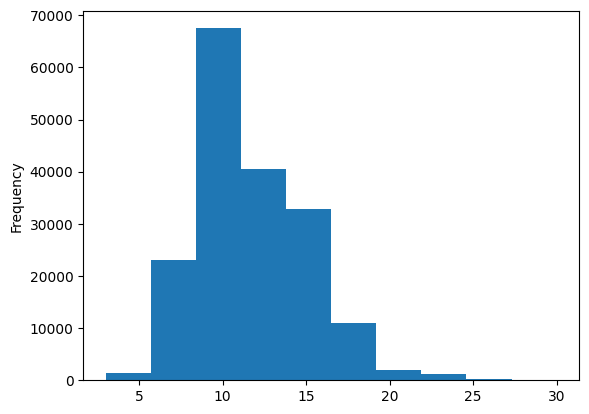

In [15]:
# Lets check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentances

In [16]:
train_sentances = train_df['text'].tolist()
val_sentances = val_df['text'].tolist()
test_sentances = test_df['text'].tolist()


In [17]:
# view the 10 lines of training sentances
train_sentances[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##Make numerica labels
Mostly ML models deal with numerical formatted data and not with string format

In [18]:
# we'll use One hot encoding to label Labels bcoz there are countable labels
from sklearn.preprocessing  import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [19]:
# extract labels ("target" columns)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [20]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from label encoder/Reverse Encoding
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#**List Of Experiments we'll perform to achieve better accuracy for our model**

0. Naive Bayes with TF_IDF encoder
1. Conv1D with token embeddings
2. Tf Pertrained Feature Extractor
3. COnv1D with char embeddings
4. Pretrained token embeddings + char embedding
5. Pretrained token embeddings + char embedding + positional embedding

## model 0: Getting a Baseline

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentances,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
from sklearn import set_config
set_config(display = 'diagram')

In [25]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentances,
              y = val_labels_encoded)

0.7218323844829869

In [26]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentances)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [27]:
val_labels_encoded   # given

array([0, 0, 3, ..., 4, 1, 1])

In [28]:
# function for accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def calculate_results(y_true, y_pred):
  """
  calculate model acuracy, precision, recall and f1 score of a binary classification model
  """
  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # calculat model precision, recall and f1-score using weigthed average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred,average = 'weighted' )

  model_results = {

                   'accuracy' :model_accuracy,
                   'precision':model_precision,
                   'recall' : model_recall,
                   'f1' : model_f1
  }
  return model_results


In [29]:
# Calculate baseline results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing our data (the text) for deep sequence models


In [30]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as layers

In [31]:
# long sentance === took average
sent_lens = [len(sentance.split()) for sentance in train_sentances]

In [32]:
avg_sent_len = np.mean(sent_lens)

In [33]:
avg_sent_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

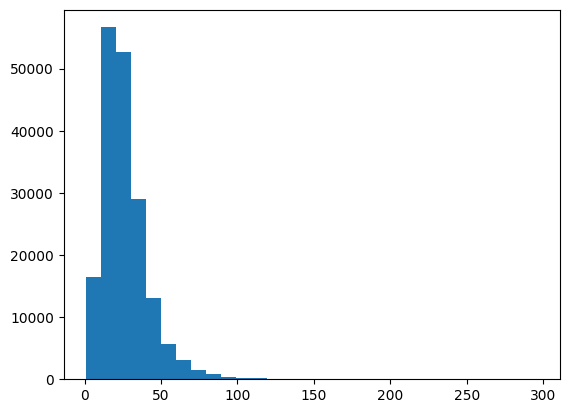

In [34]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 30)

In [35]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### create Text vectorizer layer
which turns strings to numerical vectos

In [36]:
# total words in our vocabulary(given in Paper)
max_tokens = 68000

In [37]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [38]:
# adapt text Vectorizer to training sentances
text_vectorizer.adapt(train_sentances)

In [39]:
# Test out text vectorizer on random sentances

import random
target_sentance = random.choice(train_sentances)
print(f'text:\n{target_sentance}')
print(f'\nVectorized text: {text_vectorizer([target_sentance])}')

text:
the purpose of this study is to validate the efficacy of intensive statin therapy for patients with atherosclerotic intracranial arterial stenosis ( aicas ) .

Vectorized text: [[    2   695     4    23    17    20     6  3864     2    79     4   642
   1655    66    11    12     7  5457  2844   678  1484 32765     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [40]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding


In [41]:
# token_embed = layers.Embedding(input_dim = len(rct_20k_text),
#                                output_dim = 256)

In [42]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [43]:
import tensorflow as tf

token_embed = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vocab),
                                         output_dim = 256,
                                         mask_zero = True,
                                         name = 'token_embedding')

In [44]:
print(f'Target sentance:\n{target_sentance}\n\n')
print(f'Vectorized target sentance:\n{text_vectorizer([target_sentance])}\n\n')
print(f'shape of vectorized sentance:{text_vectorizer([target_sentance]).shape}\n\n')
print(f'embedded target sentance:\n{token_embed(text_vectorizer([target_sentance]))}\n\n')
print(f'shape of embedded sentance:{token_embed(text_vectorizer([target_sentance])).shape}')

Target sentance:
the purpose of this study is to validate the efficacy of intensive statin therapy for patients with atherosclerotic intracranial arterial stenosis ( aicas ) .


Vectorized target sentance:
[[    2   695     4    23    17    20     6  3864     2    79     4   642
   1655    66    11    12     7  5457  2844   678  1484 32765     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


shape of vectorized sentance:(1, 55)


embedded target sentance:
[[[-0.01956647  0.03193006  0.02853587 ... -0.00656224 -0.0177777
    0.02066158]
  [ 0.0195755  -0.02190234  0.00623169 ...  0.01316588  0.0311918
   -0.00305908]
  [ 0.02477766  0.02775406  0.02942592 ...  0.04763189 -0.04187956
   -0.01260089]
  ...
  [ 0.04211741 -0.03071079 -0.01055036 ... -0.0078453  -0.02863256
    0.01915946]
  [ 0.04211741 -0.03071079 -0.01055036 ... -0.007

In [45]:
## Turn our data into tensorflow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentances, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentances, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentances, test_labels_one_hot))

In [46]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [47]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## model 1: Conv 1D with token embeddings

In [48]:
# Create 1D convolutional model to process sequences
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)

 # vectorize text inputs
token_embeddings = token_embed(text_vectors)

# create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# check the summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 256)          16599296  
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            81984     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [50]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/5
562/562 [==============================] - 46s 62ms/step - loss: 0.7817 - accuracy: 0.7072 - val_loss: 0.5711 - val_accuracy: 0.7866
Epoch 2/5
562/562 [==============================] - 9s 16ms/step - loss: 0.5704 - accuracy: 0.7918 - val_loss: 0.5366 - val_accuracy: 0.8059
Epoch 3/5
562/562 [==============================] - 7s 11ms/step - loss: 0.5415 - accuracy: 0.8026 - val_loss: 0.5197 - val_accuracy: 0.8102
Epoch 4/5
562/562 [==============================] - 5s 10ms/step - loss: 0.5186 - accuracy: 0.8088 - val_loss: 0.5147 - val_accuracy: 0.8092
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5247 - accuracy: 0.8084 - val_loss: 0.4891 - val_accuracy: 0.8148


In [51]:
# # Fit the model after changing pooling layer to Max from Average
# # Fit the model
# model_1_history = model_1.fit(train_dataset,
#                               steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
#                               epochs=3,
#                               validation_data=valid_dataset,
#                               validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

In [52]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4889 - accuracy: 0.8205


[0.488874226808548, 0.8205018043518066]

In [53]:
# make prediction
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[6.11635208e-01, 2.16731206e-01, 1.07400038e-03, 1.58511758e-01,
        1.20477965e-02],
       [2.58090317e-01, 6.75331533e-01, 1.66359032e-03, 4.47374135e-02,
        2.01771967e-02],
       [2.18094930e-01, 4.03110124e-02, 1.69376414e-02, 7.24196494e-01,
        4.59876639e-04],
       ...,
       [5.90570671e-05, 4.68338170e-04, 1.16086667e-02, 2.89750114e-05,
        9.87834990e-01],
       [4.42646910e-03, 7.93228447e-01, 1.03626326e-02, 1.83252327e-03,
        1.90149963e-01],
       [3.44101749e-02, 9.54158962e-01, 7.96936173e-03, 1.17821328e-03,
        2.28336384e-03]], dtype=float32)

In [54]:
# convert perd prob to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)

In [55]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [56]:
# calcuate model_1 results

model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)

In [57]:
model_1_results

{'accuracy': 82.05017873692573,
 'precision': 0.821439819728655,
 'recall': 0.8205017873692573,
 'f1': 0.8181525875656419}

In [58]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Tf Hub pretrained Feature Extractor

use pretrained embedding sfrom tf hub, https://tfhub.dev/google/universal-sentence-encoder/4

In [59]:
# Download pretrained Tf Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable = False,
                                        name = 'universal_sentance_encoder')

In [60]:
# Test out the pretrained embedding on a random sentance

random_train_sentance = random.choice(train_sentances)

print(f'Random sentance is:\n{random_train_sentance}\n\n')
print(f"embedding sentance:\n{tf_hub_embedding_layer([random_train_sentance])}\n\n")
print(tf_hub_embedding_layer([random_train_sentance]).shape)


Random sentance is:
we defined pancreatitis , bleeding , and perforation as complications of est. .


embedding sentance:
[[-7.33042583e-02  3.13530490e-02  4.35315780e-02  4.93724942e-02
   1.59692764e-02 -3.53327021e-02 -6.00342825e-02 -5.05697541e-02
   7.29620010e-02  4.80633564e-02  8.38342607e-02  3.83925512e-02
  -6.64372519e-02  6.03551753e-02 -6.16580360e-02 -5.84369106e-03
  -7.46515840e-02  6.14971444e-02 -4.70780581e-02  8.07277486e-02
  -6.12372458e-02  8.33444521e-02  3.44578587e-02 -3.41385859e-03
   4.39648889e-02 -3.54769863e-02 -1.48916142e-02  1.03731416e-02
   7.52766477e-03 -2.58147679e-02  5.68470731e-03  8.49469826e-02
  -4.45085801e-02 -1.56926531e-02 -7.36789629e-02 -1.75928082e-02
   2.50218343e-02  9.10486840e-03  7.56699070e-02 -2.72070300e-02
  -7.30455741e-02 -4.38311957e-02  4.62277010e-02  6.91202581e-02
  -4.99907918e-02 -8.96996632e-03 -2.78696883e-02 -4.35512606e-03
   3.15957330e-02  2.55415700e-02 -4.96398918e-02 -5.71198426e-02
  -4.24913578e-02  1

### build model with pretrained tf hub models


In [61]:
# define feature extraction layers
inputs = layers.Input(shape = [], dtype = tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)

x = layers.Dense(128, activation = 'relu')(pretrained_embedding)

outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_2 = tf.keras.Model(inputs,
                         outputs,
                         name = 'model_2_feature_extractor')


# compile a model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [62]:
model_2.summary()

Model: "model_2_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentance_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [63]:
# fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 5,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 13ms/step - loss: 0.9128 - accuracy: 0.6505 - val_loss: 0.7968 - val_accuracy: 0.6898
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7679 - accuracy: 0.7018 - val_loss: 0.7535 - val_accuracy: 0.7068
Epoch 3/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7498 - accuracy: 0.7128 - val_loss: 0.7361 - val_accuracy: 0.7141
Epoch 4/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7170 - accuracy: 0.7251 - val_loss: 0.7077 - val_accuracy: 0.7320
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7239 - accuracy: 0.7227 - val_loss: 0.6872 - val_accuracy: 0.7404


In [64]:
# evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.6946 - accuracy: 0.7364


[0.6945849061012268, 0.7364292144775391]

In [65]:
# make predictions with feature extraction model

model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[6.50946617e-01, 2.21016020e-01, 2.17487174e-03, 1.16977736e-01,
        8.88467487e-03],
       [3.88402939e-01, 5.17808497e-01, 4.39460808e-03, 8.71585906e-02,
        2.23537348e-03],
       [3.77037019e-01, 6.32807612e-02, 4.54513542e-02, 4.68668163e-01,
        4.55626249e-02],
       ...,
       [2.30166106e-03, 2.11379840e-03, 1.10813215e-01, 6.93605281e-04,
        8.84077728e-01],
       [3.25688277e-03, 2.50730179e-02, 4.49721098e-01, 9.91574256e-04,
        5.20957410e-01],
       [1.33825749e-01, 3.96895766e-01, 4.17522103e-01, 1.76054309e-03,
        4.99957949e-02]], dtype=float32)

In [66]:
model_2_pred = tf.argmax(model_2_pred_probs, axis = 1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [67]:
# calculate results

model_2_results = calculate_results(val_labels_encoded,
                                    model_2_pred)

In [68]:
model_2_results

{'accuracy': 73.64292334171853,
 'precision': 0.7329091328909941,
 'recall': 0.7364292334171852,
 'f1': 0.7307669712822494}

## model 3: character embeddings Conv1D
Rather than token we'll do character level embedding

Token vs Character level Embedding
---
I Love Tensorflow will become
I L o v e T e s o r f l o w

### Create a character level Embedding

In [69]:
train_sentances[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [70]:
# make function to split sentances into characters
def split_chars(text):
  return ' '.join(list(text))

# text splittin non character level squence into characters
split_chars(random_train_sentance)

'w e   d e f i n e d   p a n c r e a t i t i s   ,   b l e e d i n g   ,   a n d   p e r f o r a t i o n   a s   c o m p l i c a t i o n s   o f   e s t .   .'

In [71]:
train_chars = [split_chars(sentance) for sentance in train_sentances]
val_chars = [split_chars(sentance) for sentance in val_sentances]
test_chars = [split_chars(sentance) for sentance in test_sentances]

In [72]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [73]:
char_lens = [len(sentance) for sentance in train_sentances]
mean_char_len = np.mean(char_lens)
mean_char_len


149.3662574983337

(array([7.8590e+03, 3.5206e+04, 4.9626e+04, 4.0112e+04, 2.4025e+04,
        1.2206e+04, 5.8610e+03, 2.5790e+03, 1.2490e+03, 6.2200e+02,
        3.1400e+02, 1.5300e+02, 8.8000e+01, 5.1000e+01, 2.8000e+01,
        1.7000e+01, 1.7000e+01, 8.0000e+00, 5.0000e+00, 6.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 4.71666667e+01, 9.33333333e+01, 1.39500000e+02,
        1.85666667e+02, 2.31833333e+02, 2.78000000e+02, 3.24166667e+02,
        3.70333333e+02, 4.16500000e+02, 4.62666667e+02, 5.08833333e+02,
        5.55000000e+02, 6.01166667e+02, 6.47333333e+02, 6.93500000e+02,
        7.39666667e+02, 7.85833333e+02, 8.32000000e+02, 8.78166667e+02,
        9.24333333e+02, 9.70500000e+02, 1.01666667e+03, 1.06283333e+03,
        1.10900000e+03, 1.15516667e+03, 1.20133333e+03, 1.24750000e+03,
        1.29366667e+03, 1.33983333e+03, 1.38600000e+03]),
 <BarContainer object of 30 

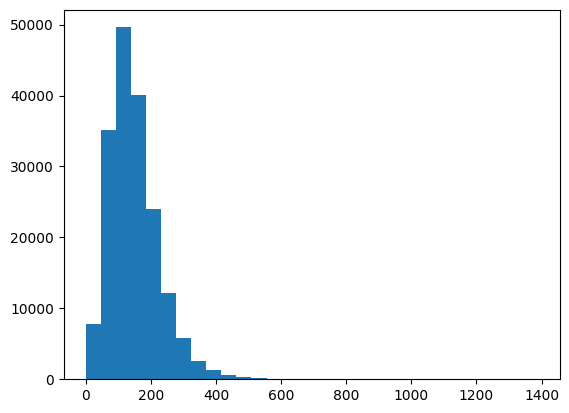

In [74]:
# check the distribution of characters
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 30)

In [75]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [76]:
# Get all ketboard characters
random.choice(train_sentances)

'no patient developed hormone-refractory or metastatic disease , and none has died from prostate cancer .'

In [77]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
# create char- level token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = None,
                                    name = 'char_vectorizer')

In [79]:
# Adapt character char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [80]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 '@',
 'y',
 'w',
 'v',
 'b',
 ',',
 '.',
 '-',
 ')',
 '(',
 'k',
 'x',
 '%',
 'z',
 '=',
 'q',
 '/',
 ';',
 'j',
 ':',
 '<',
 "'",
 '+',
 '`',
 '>',
 '$',
 '&',
 '*',
 '~',
 '?',
 '#',
 '_',
 '!',
 '|',
 '"',
 ']',
 '\\',
 '[']

In [81]:
### creating character level embedding
char_embed   = layers.Embedding(input_dim = len(char_vocab),
                                output_dim = 25,
                                mask_zero = True,
                                name = "char_embed")

In [82]:
# Test our character embedding layer

random_sent = random.choice(train_chars)


print(f"Characterized sentance : \n{random_sent}\n")
print(f"Len of sentance:{len(random_sent.split())}\n")
print(f"Embedded sentance : \n{char_vectorizer(random_sent)}\n")
print(f'len of embedded sentance(Preset): {len(char_vectorizer(random_sent))}\n')

print(f"embedded char sentance:\n{char_embed(char_vectorizer(random_sent))}\n")
print(f"shape of embedded char sentance:{char_embed(char_vectorizer(random_sent)).shape}")

Characterized sentance : 
a t   t h e   b a s e l i n e   ,   t h e r e   w e r e   n o   d i f f e r e n c e s   i n   c l i n i c a l   c h a r a c t e r i s t i c s   b e t w e e n   t h e   t w o   g r o u p s   .

Len of sentance:81

Embedded sentance : 
[ 5  3  3 13  2 23  5  9  2 12  4  6  2 24  3 13  2  8  2 21  2  8  2  6
  7 10  4 17 17  2  8  2  6 11  2  9  4  6 11 12  4  6  4 11  5 12 11 13
  5  8  5 11  3  2  8  4  9  3  4 11  9 23  2  3 21  2  2  6  3 13  2  3
 21  7 18  8  7 16 14  9 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 

### Build a COnv1D model to fit on character embeddings


In [83]:
# make Conv1D on Chars only

inputs = layers.Input(shape = (1,), dtype = 'string')

char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(128, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs,
                         outputs,
                         name = 'model_3_conv1d_char_embeddings')

# compile the model
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])



In [84]:
# summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 128)          16128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 

In [85]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [87]:
#Fit the model on chars only

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 5,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 6s 9ms/step - loss: 1.1352 - accuracy: 0.5514 - val_loss: 0.9086 - val_accuracy: 0.6493
Epoch 2/5
562/562 [==============================] - 4s 7ms/step - loss: 0.8657 - accuracy: 0.6609 - val_loss: 0.8100 - val_accuracy: 0.6888
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.7899 - accuracy: 0.6963 - val_loss: 0.7433 - val_accuracy: 0.7201
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.7461 - accuracy: 0.7171 - val_loss: 0.7068 - val_accuracy: 0.7370
Epoch 5/5
562/562 [==============================] - 4s 6ms/step - loss: 0.7247 - accuracy: 0.7253 - val_loss: 0.6828 - val_accuracy: 0.7417


In [88]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[2.1067235e-01, 5.4247087e-01, 4.4715427e-02, 1.9413985e-01,
        8.0014952e-03],
       [2.2289835e-01, 5.9206295e-01, 1.1296864e-02, 1.4855669e-01,
        2.5185062e-02],
       [9.1678523e-02, 3.3002397e-01, 1.0364331e-01, 4.3231663e-01,
        4.2337567e-02],
       ...,
       [1.2580188e-03, 2.8117255e-03, 1.2219812e-02, 8.4231142e-04,
        9.8286808e-01],
       [2.6097441e-02, 1.4401147e-01, 3.0498278e-01, 2.0567324e-02,
        5.0434095e-01],
       [2.0799358e-01, 7.4145579e-01, 2.9929409e-02, 1.8590311e-02,
        2.0308748e-03]], dtype=float32)

In [89]:
model_3_pred = tf.argmax(model_3_pred_probs, axis = 1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [90]:
# calculate results
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_pred)
model_3_results

{'accuracy': 73.84482986892625,
 'precision': 0.7424160512883,
 'recall': 0.7384482986892625,
 'f1': 0.735688362020854}

#Till Now Results of all models we built

In [91]:
print(f"Baseline model:\n{baseline_results}\n\n")
print(f'Model 1 with Word Token Embedding:\n{model_1_results}\n\n')
print(f'Model 2 Tf Hub pretrained Feature Extractor:\n{model_2_results}\n\n')
print(f'Model 3 Character level Embedding:\n{model_3_results}')

Baseline model:
{'accuracy': 72.1832384482987, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1': 0.6989250353450294}


Model 1 with Word Token Embedding:
{'accuracy': 82.05017873692573, 'precision': 0.821439819728655, 'recall': 0.8205017873692573, 'f1': 0.8181525875656419}


Model 2 Tf Hub pretrained Feature Extractor:
{'accuracy': 73.64292334171853, 'precision': 0.7329091328909941, 'recall': 0.7364292334171852, 'f1': 0.7307669712822494}


Model 3 Character level Embedding:
{'accuracy': 73.84482986892625, 'precision': 0.7424160512883, 'recall': 0.7384482986892625, 'f1': 0.735688362020854}


##Model 4: Combining pretrained token embeddings + characters embeddings ( hybrid layer)

1. Create a token - level embedding model
2. Create a character-level model (similar to `model_3` with modification)
3. Combine a series of output layers
4. build a series of output takes token and character level sequences as input sequences
5. Construct a model which takes token and character-level sequences as input and produces output

###1. Setup token inputs/model

In [92]:
token_inputs = layers.Input(shape=[], dtype = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs,
                             token_output)

###2. Setup Char inputs/model

In [93]:
char_inputs = layers.Input(shape = (1,), dtype =tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

###3. Concatenate token and char inputs (create hybrid token embedding)

In [94]:
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

###4. Create output layers - adding in Dropout

In [95]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

###5. Construct model with char and token inputs

In [96]:
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embedding")

In [97]:
# model summary
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentance_encoder (Ke  (None, 512)         256797824   ['

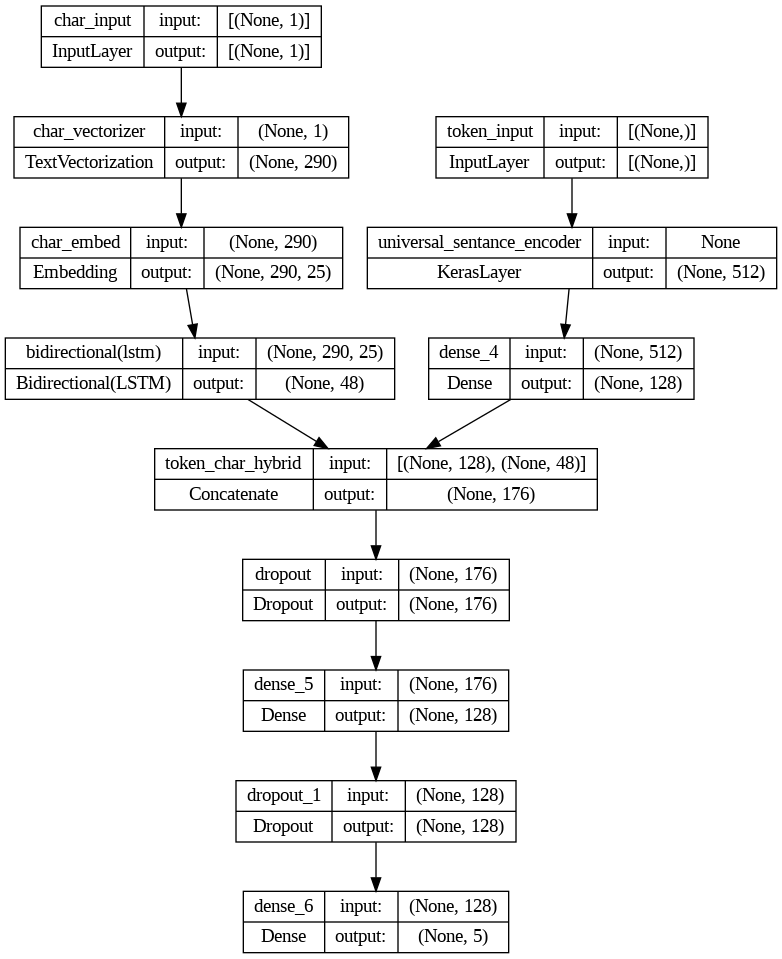

In [98]:
# Plot hybrid token and char model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [99]:
# Compile the model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

#### Combining token and character data into tf.data dataset

In [100]:
# combine chars and tokens into dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentances, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# prefetch and batch train data

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
# repeat for val data

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentances, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# prefetch and batch train data

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [102]:
# repeat for test data

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentances, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

# prefetch and batch train data

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [103]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs = 5,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 37s 46ms/step - loss: 0.9825 - accuracy: 0.6044 - val_loss: 0.7796 - val_accuracy: 0.6951
Epoch 2/5
562/562 [==============================] - 22s 38ms/step - loss: 0.7871 - accuracy: 0.6955 - val_loss: 0.7081 - val_accuracy: 0.7347
Epoch 3/5
562/562 [==============================] - 22s 39ms/step - loss: 0.7495 - accuracy: 0.7155 - val_loss: 0.6747 - val_accuracy: 0.7437
Epoch 4/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7310 - accuracy: 0.7279 - val_loss: 0.6544 - val_accuracy: 0.7500
Epoch 5/5
562/562 [==============================] - 21s 38ms/step - loss: 0.7210 - accuracy: 0.7276 - val_loss: 0.6391 - val_accuracy: 0.7593


In [104]:
# Evaluate the model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6377 - accuracy: 0.7582


[0.6377307176589966, 0.7582417726516724]

In [105]:
# make predictions using model 4
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 21ms/step


array([[5.6289351e-01, 2.7057293e-01, 4.7605471e-03, 1.5224719e-01,
        9.5258439e-03],
       [4.6744093e-01, 3.9917013e-01, 5.2600144e-03, 1.2573479e-01,
        2.3940506e-03],
       [3.8943952e-01, 9.3554422e-02, 6.1825588e-02, 4.2343700e-01,
        3.1743482e-02],
       ...,
       [4.5779569e-05, 3.9754735e-04, 1.6917635e-02, 1.5911419e-05,
        9.8262310e-01],
       [7.8273471e-03, 4.4079762e-02, 4.7649345e-01, 3.0701566e-03,
        4.6852928e-01],
       [2.3753665e-01, 5.9774107e-01, 1.3443878e-01, 5.0233514e-03,
        2.5260059e-02]], dtype=float32)

In [106]:
# format into pred labels
model_4_pred = tf.argmax(model_4_pred_probs,axis = 1)

model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>

In [107]:
# Get results of token-char_hybrid model
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_pred)
model_4_results

{'accuracy': 75.82417582417582,
 'precision': 0.756300908959798,
 'recall': 0.7582417582417582,
 'f1': 0.7544395282099141}

## Model 5: Pretrained embeddings + char embedding + positional embeddings

Feature Engineering
---
taking non obvious features from the data and encoding them numerically to help our model learn

In [108]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


###Create positional Embeddings

In [109]:
# How many  different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

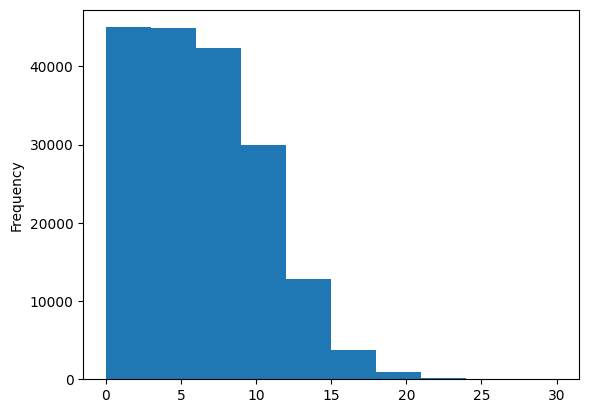

In [110]:
train_df.line_number.plot.hist()

In [111]:
train_lines_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot.shape

TensorShape([30212, 15])

In [112]:
val_line_numbers_one_hot.shape

TensorShape([30212, 15])

In [113]:
# How many  different line numbers are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

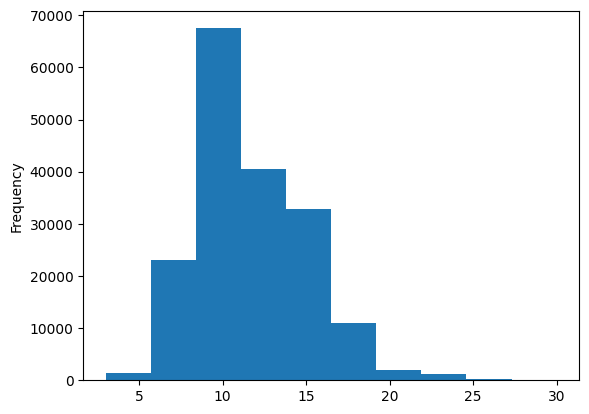

In [114]:
train_df.total_lines.plot.hist();

In [115]:
np.percentile(train_df.total_lines, 98)

20.0

In [116]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a char level model
3. Create a model for the line_number feature
4. Create a model for the total_lines feature
5. Combine the ouput of 1 & 2 using concatenate
6. Combine the output of 3,4,5 using concate
7. Create output layer
8. Combine the inputs of 1,2,3,4 and outputs

In [232]:
#1. Token Inputs

token_inputs = layers.Input(shape = [], dtype = 'string', name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs= layers.Dense(256, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs= token_outputs)


# 2. Char inputs
char_inputs = layers.Input(shape = (1, ), dtype = 'string', name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)


#3. Line numbers Model
Line_num_inputs = layers.Input(shape = (15,), dtype = tf.int32, name = 'Line_num_input')

x = layers.Dense(32, activation = 'relu')(Line_num_inputs)

line_number_model = tf.keras.Model(Line_num_inputs, x)



# 4. Total lines model

total_lines_inputs = layers.Input(shape = (20,), dtype = tf.int32, name = 'total_lines_input')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)



#5. Combine token and char embeddings into a hybrid embedings

combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output,char_model.output])
z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z) # according to paper


#6. Combine positiional embeddings with combined token and char embeddings
z = layers.Concatenate(name = 'char_token_positional_embedding')([line_number_model.output, total_line_model.output, z])


# 7. Create output layer
output_layer = layers.Dense(5, activation = 'softmax', name = 'output_layer')(z)


#Put all together
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)



In [233]:
model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentance_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

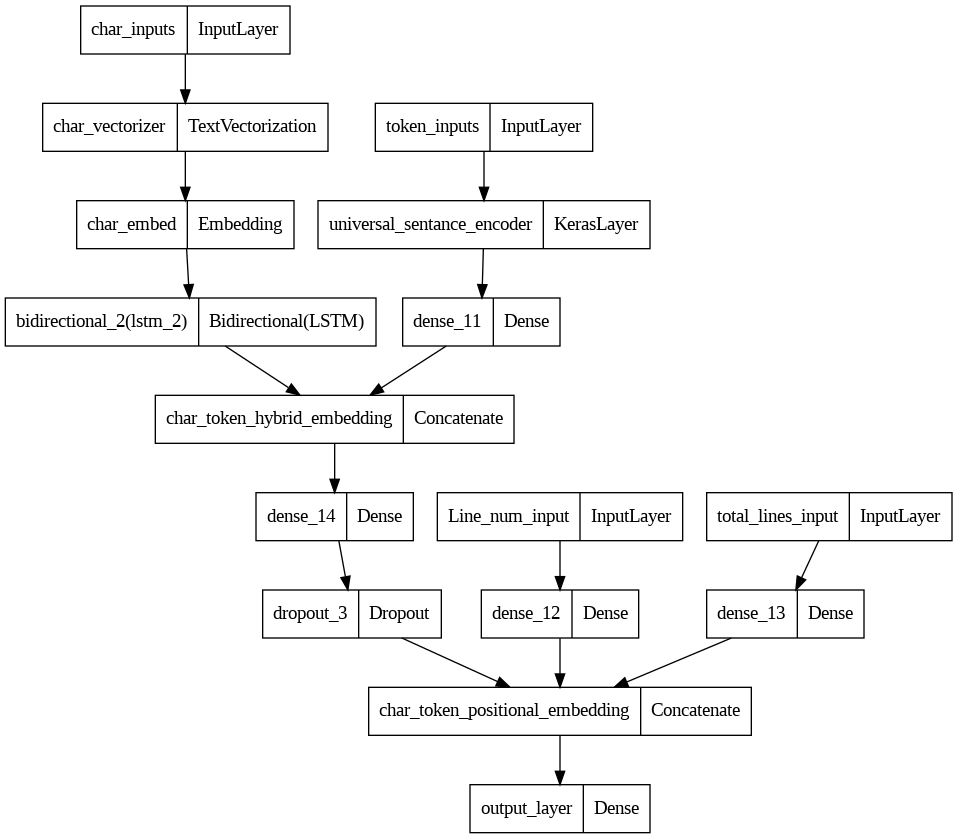

In [234]:
# plot model 5
plot_model(model_5)

In [235]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3e812988b0> True
<keras.engine.input_layer.InputLayer object at 0x7f3e8129b490> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f3eb438f7f0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f3f2859ece0> False
<keras.layers.core.embedding.Embedding object at 0x7f3eb43cfc40> True
<keras.layers.core.dense.Dense object at 0x7f3e812e91b0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f3e813fb670> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f3db029a1a0> True
<keras.engine.input_layer.InputLayer object at 0x7f3db0c3a7d0> True
<keras.engine.input_layer.InputLayer object at 0x7f3e812eab90> True
<keras.layers.core.dense.Dense object at 0x7f3db029a170> True
<keras.layers.core.dense.Dense object at 0x7f3db0c9c7c0> True
<keras.layers.core.dense.Dense object at 0x7f3db0279b10> True
<keras.layers.regularization.dropout.Dropout object at 0x7f3e80fe9660> True
<keras.layers

In [236]:
# Compile a model 5

#label smoothing = if our model gets too confident on a single class (e.g its prediction probability is really high) it my stuck on that class and not consider other classes
#....label smoothing assigns the value from high probability to other classes in turn hopefully imporving genearalization

model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Create tribrid embedding datasets using tf.data


In [237]:
#Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_lines_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentances,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# validation dataset


val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentances,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [238]:
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [239]:
len(train_char_token_pos_dataset)

5627

In [240]:
### Fit the model

model_5_history = model_5.fit(train_char_token_pos_dataset,
                              epochs = 6,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/6
562/562 [==============================] - 38s 47ms/step - loss: 1.0749 - accuracy: 0.7400 - val_loss: 0.9728 - val_accuracy: 0.7995
Epoch 2/6
562/562 [==============================] - 23s 42ms/step - loss: 0.9552 - accuracy: 0.8254 - val_loss: 0.9426 - val_accuracy: 0.8318
Epoch 3/6
562/562 [==============================] - 24s 43ms/step - loss: 0.9384 - accuracy: 0.8331 - val_loss: 0.9257 - val_accuracy: 0.8447
Epoch 4/6
562/562 [==============================] - 24s 43ms/step - loss: 0.9286 - accuracy: 0.8438 - val_loss: 0.9197 - val_accuracy: 0.8378
Epoch 5/6
562/562 [==============================] - 23s 41ms/step - loss: 0.9235 - accuracy: 0.8443 - val_loss: 0.9126 - val_accuracy: 0.8454
Epoch 6/6
562/562 [==============================] - 23s 41ms/step - loss: 0.9278 - accuracy: 0.8411 - val_loss: 0.9080 - val_accuracy: 0.8574


In [241]:
# Evaluate model 5
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.9025 - accuracy: 0.8586


[0.9025225043296814, 0.8586323261260986]

In [242]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[0.6289009 , 0.07778516, 0.01113696, 0.25203085, 0.03014624],
       [0.59425706, 0.09012451, 0.07071303, 0.22781737, 0.01708806],
       [0.31844425, 0.09722221, 0.10054266, 0.42327335, 0.06051755],
       ...,
       [0.04048575, 0.0827537 , 0.02869559, 0.03679289, 0.811272  ],
       [0.02827309, 0.47359782, 0.10796129, 0.02325648, 0.36691132],
       [0.04829863, 0.86985546, 0.03618719, 0.01634852, 0.02931018]],
      dtype=float32)

In [243]:
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [244]:
# calculate results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 85.86323315238978,
 'precision': 0.8583057368736591,
 'recall': 0.8586323315238978,
 'f1': 0.8562586987203128}

## Compare all results

In [245]:
all_models_results = pd.DataFrame({
    'model_0_baseline':baseline_results,
    'model_1_manual_token_embedding':model_1_results,
    'model_2_pretrained_token_embedding':model_2_results,
    'model_3_char_embedding':model_3_results,
    'model_4_hybrid_char_token_embedding':model_4_results,
    'model_5_tribrid_embedding':model_5_results
})

all_models_results = all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_manual_token_embedding,82.050179,0.821440,0.820502,0.818153
model_2_pretrained_token_embedding,73.642923,0.732909,0.736429,0.730767
model_3_char_embedding,73.844830,0.742416,0.738448,0.735688
model_4_hybrid_char_token_embedding,75.824176,0.756301,0.758242,0.754440
model_5_tribrid_embedding,85.863233,0.858306,0.858632,0.856259


# Save and Load Model

In [246]:
model_5.save('skimlit_tribrid_model')

In [247]:
# load best performing model
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [248]:
# make prediction from loaded model
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_pred = tf.argmax(loaded_pred_probs, axis = 1)
loaded_pred

945/945 [==============================] - 23s 21ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [249]:
loaded_result=calculate_results(val_labels_encoded, loaded_pred)

In [250]:
loaded_result

{'accuracy': 85.86323315238978,
 'precision': 0.8583057368736591,
 'recall': 0.8586323315238978,
 'f1': 0.8562586987203128}

In [251]:
model_5_results

{'accuracy': 85.86323315238978,
 'precision': 0.8583057368736591,
 'recall': 0.8586323315238978,
 'f1': 0.8562586987203128}

In [252]:
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 24s 22ms/step - loss: 0.9025 - accuracy: 0.8586


[0.9025225043296814, 0.8586323261260986]

# Test model 5 With Test Dataset

In [253]:
test_line_numbers_one_hot

<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [254]:
test_total_lines_one_hot

<tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

In [255]:
len(test_sentances)

30135

In [256]:
len(test_chars)

30135

In [257]:
# test dataset using tf.data

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentances,
                                                               test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_pos_token_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_pos_token_dataset = test_char_pos_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_char_pos_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [258]:
test_pred_probs = loaded_model.predict(test_char_pos_token_dataset,verbose = 1)
test_pred_probs

942/942 [==============================] - 19s 20ms/step


array([[0.2923942 , 0.07725111, 0.12431006, 0.3529195 , 0.1531251 ],
       [0.2441279 , 0.04577639, 0.38617203, 0.24638428, 0.07753935],
       [0.07892819, 0.03424829, 0.7581772 , 0.08226219, 0.04638398],
       ...,
       [0.0637493 , 0.13635868, 0.05521921, 0.05400518, 0.69066757],
       [0.07043586, 0.11914893, 0.0640187 , 0.05437544, 0.69202113],
       [0.0674156 , 0.68874526, 0.1032083 , 0.0391368 , 0.10149405]],
      dtype=float32)

In [259]:
test_pred = tf.argmax(test_pred_probs,axis = 1)
test_pred

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [260]:
loaded_model_test_result = calculate_results(test_labels_encoded,test_pred)
loaded_model_test_result

{'accuracy': 85.31275925004148,
 'precision': 0.8523293631933501,
 'recall': 0.8531275925004148,
 'f1': 0.8506141234233024}

## Find Most Wrong among test data

In [261]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_pred]
test_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESUL

In [262]:
test_df.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.430678,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.378771,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.745400,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.729170,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.722098,True


In [263]:
test_df['prediction'] = test_pred_classes  #column containing models prediction
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis = 1).numpy()  # prediction probability
test_df['correct'] = test_df['prediction'] == test_df['target']

test_df.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.352919,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.386172,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.758177,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.522863,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.660572,True


## Make Prediction on external Text Abstract

In [264]:
import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", 'r') as f:
    example_abstracts = json.load(f)


example_abstracts

--2023-07-14 13:06:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-07-14 13:06:30 (86.8 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [265]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [266]:
from spacy.lang.en import English

nlp = English()

sentencizer = nlp.add_pipe('sentencizer')

doc = nlp(example_abstracts[3]['abstract'])

abstract_lines = [str(sent) for sent in list(doc.sents)]

abstract_lines



['Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.',
 'There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.',
 'Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).',
 'Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.',
 "The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.",
 'Any patient with HCV infection was selected for this analysis.',
 'Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d.',
 'and 12 received placebo for 12-weeks.',
 'With respect to the placeb

In [267]:
# Get total number of lines

total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i
    sample_dict['total_lines'] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)

sample_lines

[{'text': 'Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.',
  'line_number': 0,
  'total_lines': 11},
 {'text': 'There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.',
  'line_number': 1,
  'total_lines': 11},
 {'text': 'Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).',
  'line_number': 2,
  'total_lines': 11},
 {'text': 'Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.',
  'line_number': 3,
  'total_lines': 11},
 {'text': "The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.",
  'line_number': 4,
  'total_lines': 11},
 {'text': 'Any patient with HCV 

In [268]:
# one hot encoding

test_abstract_line_numbers = [line['line_number'] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(12, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
      dtype=float32)>

In [269]:
test_abstract_total_lines =[line['total_lines'] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(12, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [270]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['H e p a t i t i s   C   v i r u s   ( H C V )   a n d   a l c o h o l i c   l i v e r   d i s e a s e   ( A L D ) ,   e i t h e r   a l o n e   o r   i n   c o m b i n a t i o n ,   c o u n t   f o r   m o r e   t h a n   t w o   t h i r d s   o f   a l l   l i v e r   d i s e a s e s   i n   t h e   W e s t e r n   w o r l d .',
 'T h e r e   i s   n o   s a f e   l e v e l   o f   d r i n k i n g   i n   H C V - i n f e c t e d   p a t i e n t s   a n d   t h e   m o s t   e f f e c t i v e   g o a l   f o r   t h e s e   p a t i e n t s   i s   t o t a l   a b s t i n e n c e .',
 'B a c l o f e n ,   a   G A B A ( B )   r e c e p t o r   a g o n i s t ,   r e p r e s e n t s   a   p r o m i s i n g   p h a r m a c o t h e r a p y   f o r   a l c o h o l   d e p e n d e n c e   ( A D ) .',
 'P r e v i o u s l y ,   w e   p e r f o r m e d   a   r a n d o m i z e d   c l i n i c a l   t r i a l   ( R C T ) ,   w h i c h   d e m o n s t r a t e d   t h e   s a f e t y   a n d   e f 

In [271]:
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))

test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step


array([[0.47047898, 0.01302062, 0.19853944, 0.22650225, 0.09145864],
       [0.6370708 , 0.05100697, 0.07472127, 0.19808528, 0.03911569],
       [0.44850984, 0.07045548, 0.2245141 , 0.19777668, 0.05874394],
       [0.22707514, 0.07570156, 0.48037   , 0.13976651, 0.07708672],
       [0.26581994, 0.13517652, 0.13539276, 0.28349802, 0.18011275],
       [0.03655271, 0.04092853, 0.48332277, 0.03335442, 0.4058415 ],
       [0.01394639, 0.05475498, 0.2878793 , 0.02197357, 0.6214458 ],
       [0.03717626, 0.08627345, 0.59196573, 0.03645714, 0.24812737],
       [0.02311861, 0.04340211, 0.0276802 , 0.02979175, 0.8760074 ],
       [0.0282259 , 0.10812344, 0.00857919, 0.0314743 , 0.82359713],
       [0.04482322, 0.7013323 , 0.02283058, 0.03272098, 0.19829293],
       [0.04175333, 0.87754273, 0.01941392, 0.02529236, 0.03599774]],
      dtype=float32)

In [272]:
# Turn into prediction classes
test_abstract_pred = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_pred

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([0, 0, 0, 2, 3, 2, 4, 2, 4, 4, 1, 1])>

In [273]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_pred]
test_abstract_pred_classes

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'OBJECTIVE',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [274]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):

  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.
BACKGROUND: There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.
BACKGROUND: Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).
METHODS: Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.
OBJECTIVE: The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.
METHODS: Any patient with HCV infection was selected for this analysis.
RESULTS: Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d.
METHODS: and 12 received

In [275]:
output_dict = {}

for i, j in zip(test_abstract_pred_classes, abstract_lines):
  if i in output_dict:
    output_dict[i].append(j)
  else:
    output_dict[i] = [j]

# output_dict


In [276]:
for i, j in output_dict.items():
  print(f"{i}:")
  for v in j:
    print(f"{v}")
  print()

BACKGROUND:
Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.
There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.
Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).

METHODS:
Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.
Any patient with HCV infection was selected for this analysis.
and 12 received placebo for 12-weeks.

OBJECTIVE:
The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.

RESULTS:
Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d.
With respect to 